# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset.

In [1]:
import os
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy  

/mnt/data/miniconda3/envs/gr00t/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data/miniconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-07-26 10:09:58.590816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-26 10:09:58.590877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one h

In [2]:
# change the following paths
MODEL_PATH = "/mnt/data/outputs_action/checkpoint-12000" # "nvidia/GR00T-N1.5-3B"

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "/mnt/data/franka_lerobot_dataset/")
EMBODIMENT_TAG = "new_embodiment"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Loading Pretrained Policy

Policy Model is loaded just like any other huggingface model.

There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [3]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP


data_config = DATA_CONFIG_MAP["so100"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()

policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


Model not found or avail in the huggingface hub. Loading from local path: /mnt/data/outputs_action/checkpoint-12000
Loading pretrained dual brain from /mnt/data/outputs_action/checkpoint-12000
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /mnt/data/outputs_action/checkpoint-12000
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 13.12it/s]


Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
GR00T_N1_5(
  (backbone): EagleBackbone(
    (eagle_model): Eagle2_5_VLForConditionalGeneration(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_f

## Loading dataset

First this requires user to check which embodiment tags are used to pretrained the `Gr00tPolicy` pretrained models.

In [4]:
import numpy as np

modality_config = policy.modality_config

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


dict_keys(['video', 'state', 'action', 'language'])
video delta_indices=[0] modality_keys=['video.left', 'video.right', 'video.wrist']
state delta_indices=[0] modality_keys=['state.single_arm', 'state.gripper']
action delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] modality_keys=['action.single_arm', 'action.gripper']
language delta_indices=[0] modality_keys=['annotation.human.task_description']


In [5]:
# Create the dataset
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset franka_lerobot_dataset with new_embodiment


Let's print out a single data and visualize it

In [6]:
# import numpy as np

# step_data = dataset[0]

# print(step_data["video.left"].max(), step_data["video.left"].min())

# print("\n\n ====================================")
# for key, value in step_data.items():
#     if isinstance(value, np.ndarray):
#         print(key, value.shape)
#     else:
#         print(key, value)
## trajectory_id,step_count
data_point = dataset.get_step_data(84, 3 )
print(data_point["action.single_arm"].shape)
# predicted_action = policy.get_action(data_point["state.single_arm"])
# print(predicted_action)

(16, 7)


Let's plot just the "right hand" state and action data and see how it looks like. Also show the images of the right hand state.

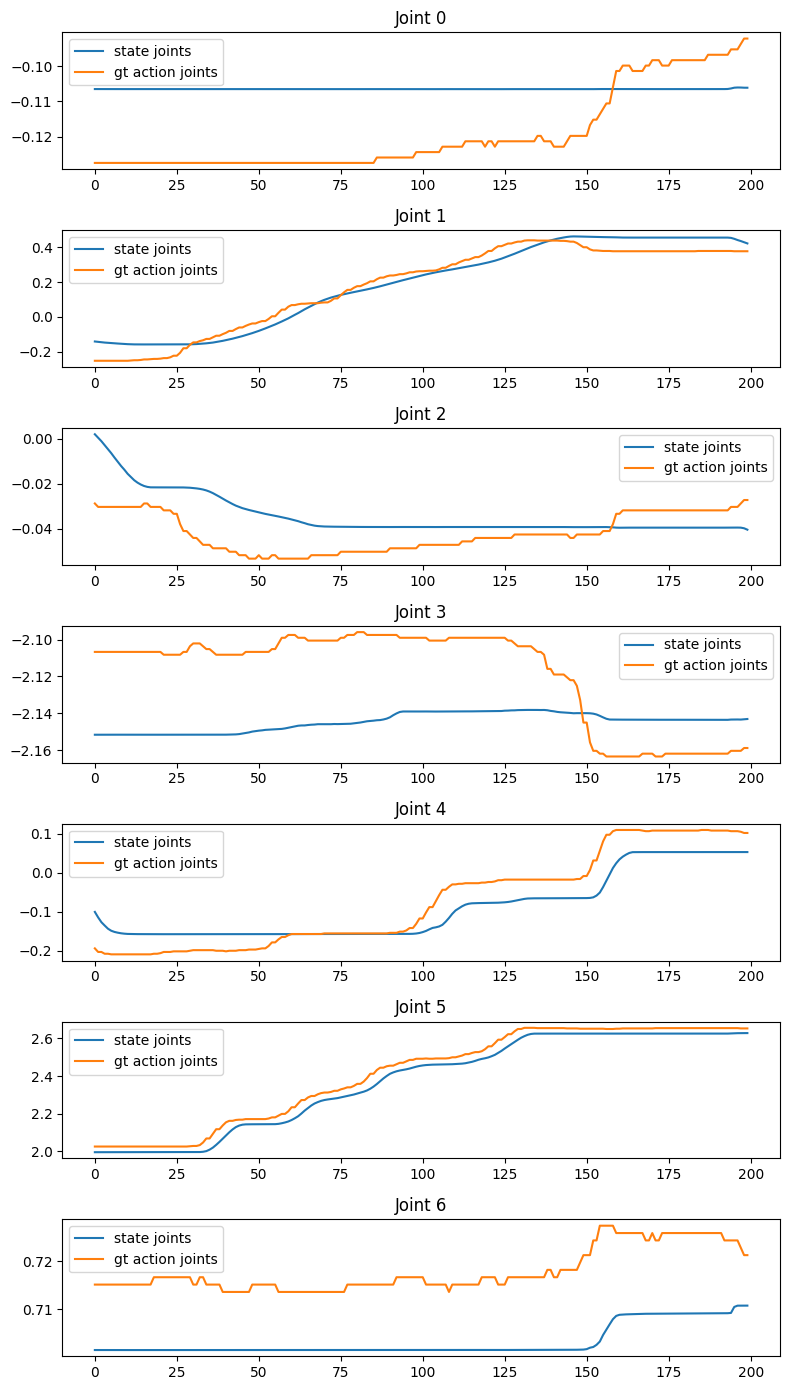

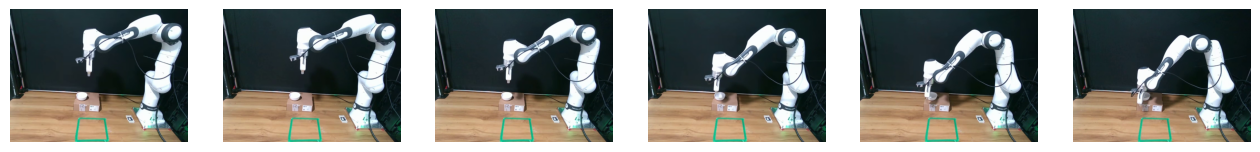

In [7]:
import matplotlib.pyplot as plt

traj_id = 1
max_steps = 200

state_joints_across_time = []
gt_action_joints_across_time = []
images = []

sample_images = 6

for step_count in range(max_steps):
    data_point = dataset.get_step_data(traj_id, step_count)
    state_joints = data_point["state.single_arm"][0]
    gt_action_joints = data_point["action.single_arm"][0]
    
   
    state_joints_across_time.append(state_joints)
    gt_action_joints_across_time.append(gt_action_joints)

    # We can also get the image data
    if step_count % (max_steps // sample_images) == 0:
        image = data_point["video.left"][0]
        images.append(image)

# Size is (max_steps, num_joints == 7)
state_joints_across_time = np.array(state_joints_across_time)
gt_action_joints_across_time = np.array(gt_action_joints_across_time)


# Plot the joint angles across time
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 2*7))

for i, ax in enumerate(axes):
    ax.plot(state_joints_across_time[:, i], label="state joints")
    ax.plot(gt_action_joints_across_time[:, i], label="gt action joints")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()


# Plot the images in a row
fig, axes = plt.subplots(nrows=1, ncols=sample_images, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")
    

Now we can run the policy from the pretrained checkpoint.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_predictions_vs_ground_truth(dataset, policy, traj_id=0, max_steps=100):
    # Initialize lists to store data
    state_joints = []
    gt_actions = []
    pred_actions = []
    images = []
    sample_images = 6  # Number of images to sample for visualization

    # Collect data
    for step_count in tqdm(range(max_steps), desc="Collecting predictions"):
        # Get current data point
        data_point = dataset.get_step_data(traj_id, step_count)
        
        # Store state and ground truth action
        state_joints.append(data_point["state.single_arm"][0])
        gt_actions.append(data_point["action.single_arm"][0])
        
        # Get model prediction
        with torch.no_grad():
            predicted_action = policy.get_action(data_point)
            pred_actions.append(predicted_action["action.single_arm"][0])
        
        # Sample some images for visualization
        if step_count % (max_steps // sample_images) == 0:
            images.append(data_point["video.left"][0])

    # Convert to numpy arrays
    state_joints = np.array(state_joints)  # [max_steps, num_joints]
    gt_actions = np.array(gt_actions)      # [max_steps, num_joints]
    pred_actions = np.array(pred_actions)  # [max_steps, num_joints]

    # Calculate errors
    errors = np.abs(gt_actions - pred_actions)
    mae = np.mean(errors, axis=0)
    print(f"Mean Absolute Error per joint:")
    for i, error in enumerate(mae):
        print(f"  Joint {i}: {error:.4f}")

    # Plot joint angles and actions
    num_joints = state_joints.shape[1]
    fig, axes = plt.subplots(num_joints, 1, figsize=(12, 2*num_joints))
    if num_joints == 1:
        axes = [axes]  # Ensure axes is iterable for single joint case

    for i, ax in enumerate(axes):
        # Plot state (current joint positions)
        ax.plot(state_joints[:, i], 'b-', label='State', alpha=0.7)
        
        # Plot ground truth actions
        ax.plot(gt_actions[:, i], 'g-', label='GT Action', alpha=0.7)
        
        # Plot predicted actions
        ax.plot(pred_actions[:, i], 'r--', label='Predicted', alpha=0.9)
        
        # Add error shading
        ax.fill_between(
            range(len(gt_actions)),
            gt_actions[:, i] - errors[:, i],
            gt_actions[:, i] + errors[:, i],
            color='gray',
            alpha=0.2,
            label='Error'
        )
        
        ax.set_title(f'Joint {i} | MAE: {mae[i]:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Joint States and Actions Over Time', y=1.02)
    plt.show()

    # Plot sampled images
    fig, axes = plt.subplots(1, len(images), figsize=(16, 4))
    if len(images) == 1:
        axes = [axes]  # Ensure axes is iterable for single image case
        
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return {
        'state_joints': state_joints,
        'gt_actions': gt_actions,
        'pred_actions': pred_actions,
        'mae': mae
    }



Mean Absolute Error per joint:
  Joint 0: 0.0234
  Joint 1: 0.0362
  Joint 2: 0.0252
  Joint 3: 0.0252
  Joint 4: 0.0263
  Joint 5: 0.0416
  Joint 6: 0.0151


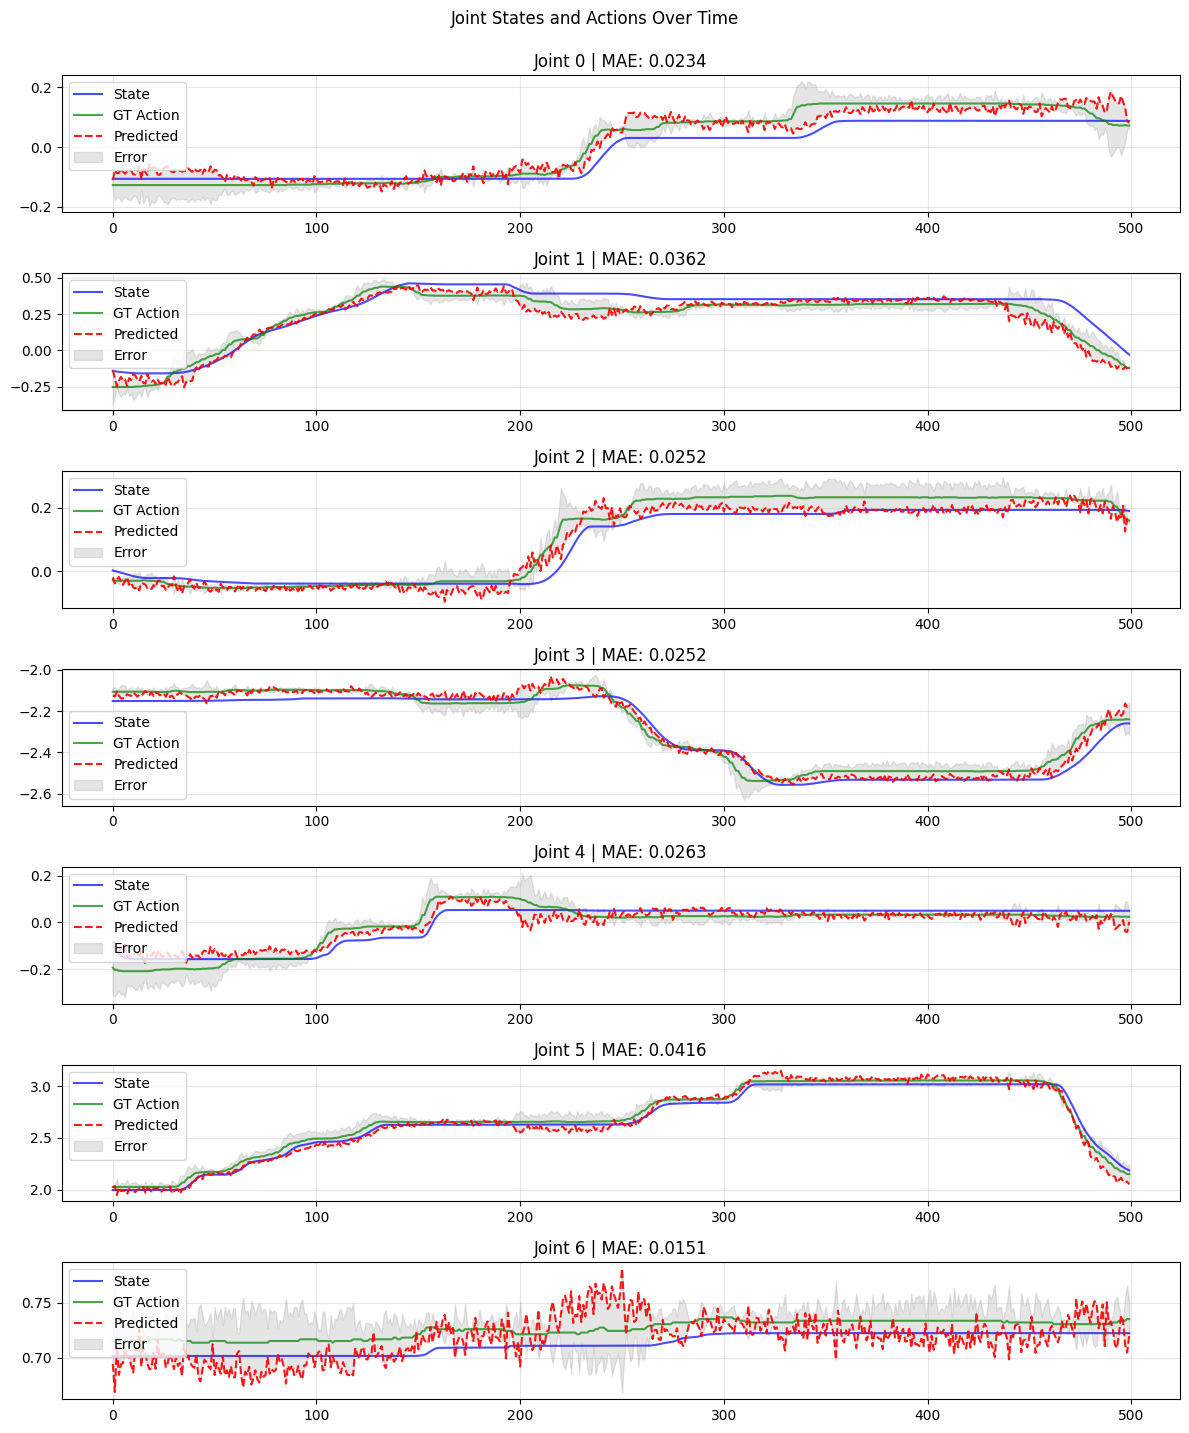

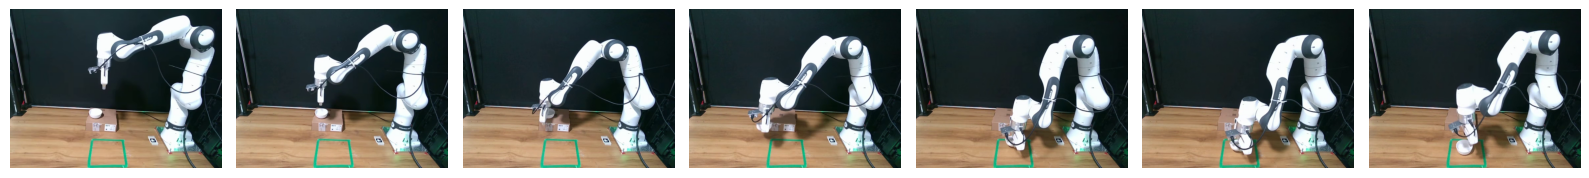

In [12]:
results = plot_predictions_vs_ground_truth(
    dataset=dataset,
    policy=policy,
    traj_id=1,      # Which trajectory to visualize
    max_steps=500   # How many steps to process
)

In [10]:
import numpy as np
np.save("test.npy", results["pred_actions"])

In [17]:
for action in results["pred_actions"]:
    print(action)

[-0.11060542 -0.13726339 -0.01969704 -2.12484169 -0.08001709  2.01792383
  0.69418949]
[-0.07768175 -0.18933079 -0.03861782 -2.12986541 -0.08716577  2.03526068
  0.66874814]
[-0.08748087 -0.2473579  -0.0261071  -2.10570717 -0.10230112  1.94553924
  0.71064246]
[-0.08686599 -0.20899479 -0.01807854 -2.12611699 -0.12070048  2.01975584
  0.68431592]
[-0.07321516 -0.18278784 -0.0321236  -2.13890076 -0.1050089   1.98472643
  0.69395047]
[-0.08222154 -0.2084934  -0.04303744 -2.13859129 -0.11437249  1.98878956
  0.69522929]
[-0.0893113  -0.199992   -0.032105   -2.13673973 -0.09703779  1.99437189
  0.70697922]
[-0.08180758 -0.24436215 -0.01883519 -2.11849856 -0.15228391  1.95487404
  0.70094705]
[-0.07707474 -0.19207752 -0.04264769 -2.12359858 -0.14239246  2.00489068
  0.70089012]
[-0.07827482 -0.2048977  -0.03528011 -2.12722611 -0.14602727  1.98591137
  0.69305825]
[-0.09093159 -0.16613236 -0.05064332 -2.11147904 -0.14019513  1.98729312
  0.68645358]
[-0.09196681 -0.17291024 -0.05477333 -2.118

In [21]:
data_test =  dataset.get_step_data(0, 0)
data_test["state.gripper"]

array([[0.03997688]])

### Understanding the Action Output

Each joint in the action output has a shape of (16, N) where N is the degree of freedom for the joint.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)

For each arm (left and right):
- 7 arm joints:
  - Shoulder pitch
  - Shoulder roll
  - Shoulder yaw
  - Elbow pitch
  - Wrist yaw
  - Wrist roll
  - Wrist pitch

For each hand (left and right):
- 6 finger joints:
  - Little finger
  - Ring finger
  - Middle finger
  - Index finger
  - Thumb rotation
  - Thumb bending

For the waist
- 3 joints:
  - torso waist yaw
  - torso waist pitch
  - torso waist roll
